# COVID-19 Data Science Challenge Protect Purdue: Predicting social crowding in Tippecanoe county

# Background


This information has been deleted by the IronHacks Team

# Log, imports, and config file

In [ ]:

%logstop
%logstart -t -r -q ipython_command_log.py global

#- IRONHACKS RESEARCH TRACKING CODE
#----------------------------------
# The following code is used to help our research team understand how you 
# our notebook environment. We do not collect any personal information with
# the following code, it is used to measure when and how often you work on
# your submission files.

import os
from datetime import datetime
import IPython.core.history as history

ha = history.HistoryAccessor()
ha_tail = ha.get_tail(1)
ha_cmd = next(ha_tail)
session_id = str(ha_cmd[0])
command_id = str(ha_cmd[1])
timestamp = datetime.utcnow().isoformat()
history_line = ','.join([session_id, command_id, timestamp]) + '\n'
logfile = open(os.environ['HOME']+'/ipython_session_log.csv', 'a')
logfile.write(history_line)
logfile.close()

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics

In [ ]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] ='key.json'
bigquery_client = bigquery.Client(project='ironhacks-covid19-data')

### Database tables:
* ironhacks-covid19-data.ironhacks_covid19_competition.weekly_patterns
* ironhacks-covid19-data.ironhacks_covid19_competition.mobility_graph
* ironhacks-covid19-data.ironhacks_covid19_competition.cbg_social_distancing
* ironhacks-covid19-data.ironhacks_covid19_competition.covid19_cases
* ironhacks-covid19-data.ironhacks_covid19_competition.executive_orders
* ironhacks-covid19-data.ironhacks_covid19_competition.prediction_list_poi

# Data visualization

### SQL table: weekly_patterns

Query and plot the number of data entries for each week.

In [ ]:
QUERY = """
SELECT week_number, Count(*) as count
FROM ironhacks-covid19-data.ironhacks_covid19_competition.weekly_patterns
GROUP BY week_number
ORDER BY week_number
"""
query_job = bigquery_client.query(QUERY)
week_number_count = query_job.to_dataframe()
week_number_count.head(10)

,week_number,count
0,11,1612
1,12,1578
2,13,1564
3,14,1571
4,15,1548
5,16,1571
6,17,1585
7,20,1616
8,21,1612
9,22,1623


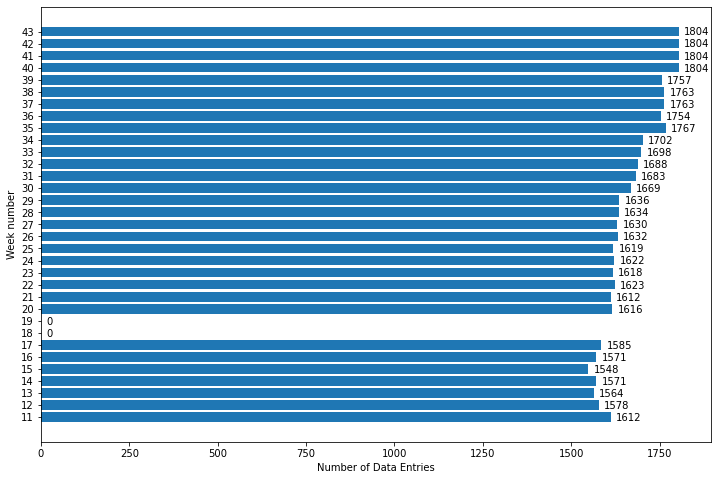

In [ ]:
## fill the missing weeks' data with 0
week_number_count_array = np.insert(week_number_count.to_numpy(), 7, np.array([[18, 0],[19,0]]), axis=0)
# draw a bar plot
week_number = week_number_count_array[:,0]
week_count = week_number_count_array[:,1]
plt.figure(figsize=(12,8))
plt.barh(week_number, week_count)
plt.yticks(week_number)
plt.ylabel("Week number")
plt.xlabel("Number of Data Entries")
for i, v in enumerate(week_count):
    plt.text(v + 15, i + 10.7, str(v))
plt.show()

The query result shows that week 18, and week 19 data are missing. Week 40, 41, 42, 43 have 1804 entries, which are the most. Therefore, use the week 40 data to furture explore the data.

In [ ]:
QUERY = """
SELECT Count(DISTINCT(poi_id)) as N_POI
FROM ironhacks-covid19-data.ironhacks_covid19_competition.weekly_patterns
WHERE week_number = 40
"""
query_job = bigquery_client.query(QUERY)
week_40_count = query_job.to_dataframe()
week_40_count

,N_POI
0,1804


Using _DISTINCT_ to count the number of unique POIs recorded in __week 40__ and the result indicates that all 1804 data entries are from different POIs, respectively.

## Choose data from week 40 to explore the POI's information 
### City

In [ ]:
QUERY = """
SELECT city, Count(1) as N_city
FROM ironhacks-covid19-data.ironhacks_covid19_competition.weekly_patterns
WHERE week_number = 40
GROUP BY city
ORDER BY N_city DESC
"""
query_job = bigquery_client.query(QUERY)
week_40_city_count = query_job.to_dataframe()
week_40_city_count

,city,N_city
0,Lafayette,1254
1,West Lafayette,474
2,Battle Ground,20
3,Dayton,14
4,Shadeland,8
5,Romney,7
6,West Point,7
7,Stockwell,5
8,Americus,5
9,Clarks Hill,3


In [ ]:
city_count = {}
for i in range(len(week_40_city_count)):
    if(week_40_city_count["city"][i] == "W Lafayette"):
        city_count["West Lafayette"] += week_40_city_count["N_city"][i]
    elif(week_40_city_count["city"][i] == "La Fayette"):
        city_count["Lafayette"] += week_40_city_count["N_city"][i]
    else:
        city_count[week_40_city_count["city"][i]] = week_40_city_count["N_city"][i]

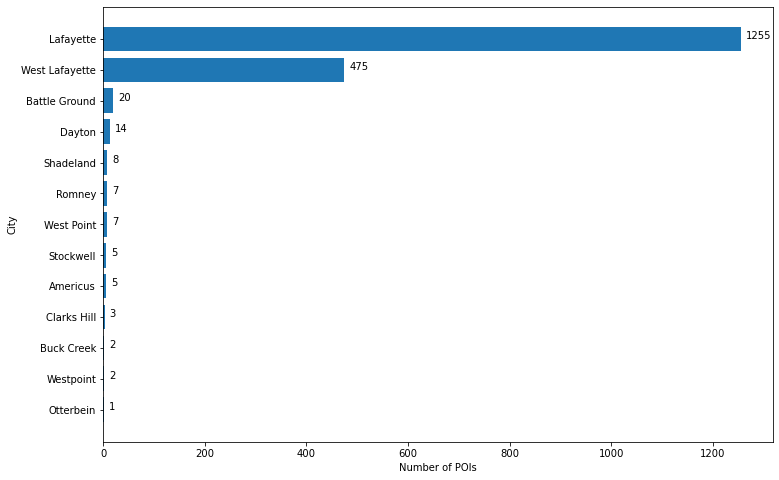

In [ ]:
city_label = list(city_count.keys())[::-1]
city_poi_count = list(city_count.values())[::-1]
plt.figure(figsize=(12,8))
plt.barh(city_label, city_poi_count)
plt.yticks(city_label)
plt.ylabel("City")
plt.xlabel("Number of POIs")
for i, v in enumerate(city_poi_count):
    plt.text(v + 10, i, str(v))
plt.show()

By count the POI numbers inside each city, the bar plot result shows that Lafayette has the most number of POIs, which is 1255. West lafayette ranks second place with 475 POIs. Other cities fall far behind those two cities. This can be served as a __Categorical Feature__.

### Postal_code

In [ ]:
QUERY = """
SELECT postal_code, Count(1) as N_postal
FROM ironhacks-covid19-data.ironhacks_covid19_competition.weekly_patterns
WHERE week_number = 40
GROUP BY postal_code
ORDER BY N_postal DESC
"""
query_job = bigquery_client.query(QUERY)
week_40_post_code_count = query_job.to_dataframe()
week_40_post_code_count

,postal_code,N_postal
0,47905,651
1,47906,446
2,47904,296
3,47909,204
4,47901,126
5,47907,37
6,47920,13
7,47992,9
8,47941,8
9,47981,7


In [ ]:
post_code_count = {}
for i in range(len(week_40_post_code_count)):
        post_code_count[week_40_post_code_count["postal_code"][i]] = week_40_post_code_count["N_postal"][i]

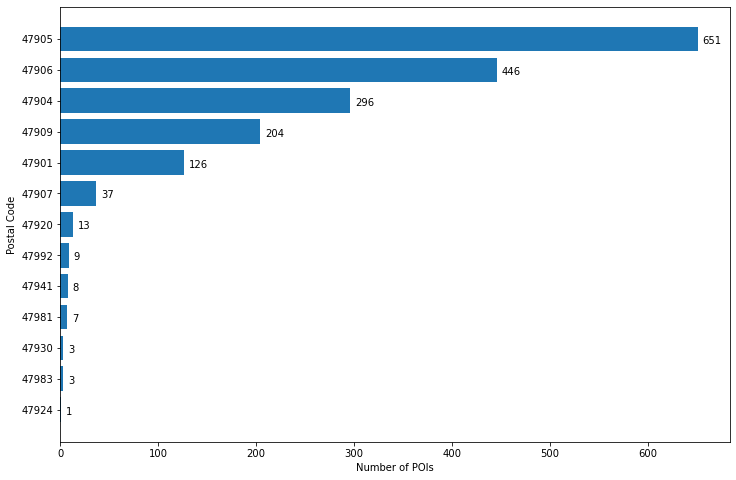

In [ ]:
post_code_label = list(map(str, list(post_code_count.keys())[::-1]))
post_code_value = list(post_code_count.values())[::-1]
plt.figure(figsize=(12,8))
plt.barh(post_code_label, post_code_value)
plt.ylabel("Postal Code")
plt.xlabel("Number of POIs")
for i, v in enumerate(post_code_value):
    plt.text(v + 5, i - 0.15, str(v))
plt.show()

From the bar plot, postcode __47905__ has the most POIs. Also, __47905__ is located in Lafayette, which also aligns with the previous city result. This can be served as a __Categorical Feature__. Moreover, there are more postcodes that cities, which both represent the location information of the POIs. Thus, choose postcodes as a feature will show a more detailed location information than cities.

### Top_category

In [ ]:
QUERY = """
SELECT top_category, Count(1) as N_category
FROM ironhacks-covid19-data.ironhacks_covid19_competition.weekly_patterns
WHERE week_number = 40
GROUP BY top_category
ORDER BY N_category DESC
"""
query_job = bigquery_client.query(QUERY)
week_40_category_count = query_job.to_dataframe()
week_40_category_count.head(10)

,top_category,N_category
0,Restaurants and Other Eating Places,351
1,"Museums, Historical Sites, and Similar Institu...",107
2,Religious Organizations,83
3,Automotive Repair and Maintenance,63
4,Other Amusement and Recreation Industries,61
5,Offices of Physicians,56
6,Health and Personal Care Stores,49
7,Elementary and Secondary Schools,49
8,Offices of Dentists,48
9,Personal Care Services,48


In [ ]:
category_count = {}
for i in range(len(week_40_category_count)):
    if(week_40_category_count["top_category"][i] is None):
        category_count["None"] = week_40_category_count["N_category"][i]
    else:
        category_count[week_40_category_count["top_category"][i]] = week_40_category_count["N_category"][i]

In [ ]:
len(category_count)

105

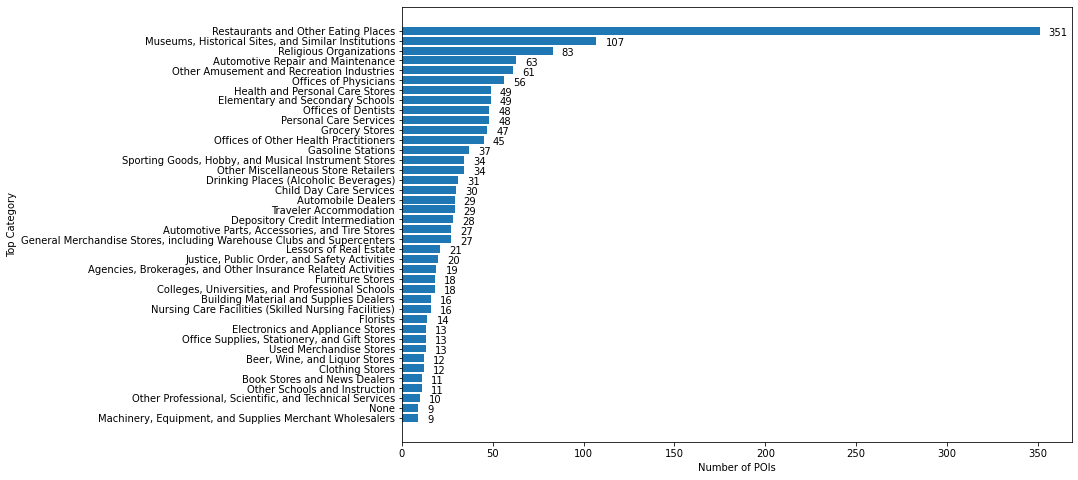

In [ ]:
category_label = list(category_count.keys())[:40][::-1]
category_value = list(category_count.values())[:40][::-1]
plt.figure(figsize=(12,8))
plt.barh(category_label, category_value)
plt.ylabel("Top Category")
plt.xlabel("Number of POIs")
for i, v in enumerate(category_value):
    plt.text(v + 5, i - 0.5, str(v))
plt.show()

The summary of the top _40_ categories from the total of _105_ different categories in the listed POIs shows that "Restaurants and Other Eating Places" is the largest group of POIs. Total of 351 POIs is below this category. This can be served as a __Categorical Feature__. Notice that there are 9 POIs with a "None" category in the top 40 categories.

### Number of weeks in the database for each POI

In [ ]:
QUERY = """
SELECT week_count, COUNT(week_count) as number_of_POI
FROM (
    SELECT poi_id, COUNT(week_number) as week_count
    FROM ironhacks-covid19-data.ironhacks_covid19_competition.weekly_patterns
    GROUP BY poi_id
    ORDER BY week_count DESC
)
GROUP BY week_count
ORDER BY number_of_POI
"""
query_job = bigquery_client.query(QUERY)
poi_weeks = query_job.to_dataframe()

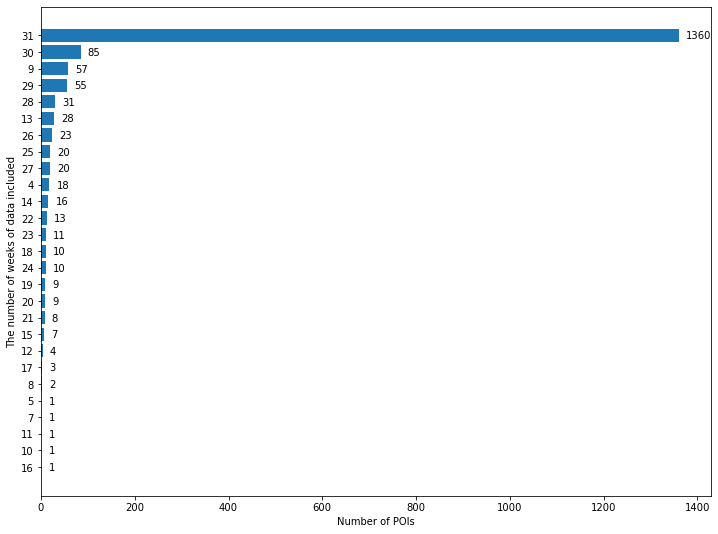

In [ ]:
week_count_label = list(map(str, list(poi_weeks["week_count"])))
number_of_POI = list(poi_weeks["number_of_POI"])
plt.figure(figsize=(12,9))
plt.barh(week_count_label, number_of_POI)
plt.yticks(week_count_label)
plt.ylabel("The number of weeks of data included")
plt.xlabel("Number of POIs")
for i, v in enumerate(number_of_POI):
    plt.text(v + 15, i - 0.2, str(v))
plt.show()

Considering there are two weeks of data missing, the dataset has 1360 POIs with all weeks POI visitor information. Analysis of the sample of those POIs' data may reveal some other information about the numerical features since it can be a continuous feature.

### Select 10 POIs with all weeks data

In [ ]:
# select 10 of 1360 POIs with all weeks' data and further explore the numerical variables
QUERY = """
SELECT poi_id
FROM (
    SELECT poi_id, COUNT(week_number) as week_count
    FROM ironhacks-covid19-data.ironhacks_covid19_competition.weekly_patterns
    GROUP BY poi_id
)
WHERE week_count = 31
LIMIT 10
"""
query_job = bigquery_client.query(QUERY)
ten_poi_with_all_weeks = query_job.to_dataframe()
ten_poi_with_all_weeks

,poi_id
0,6a2d40f8-c477-49b6-a5d5-69c31f001afc
1,49636347-5a9d-4bf3-9d9a-c21a4ba7d8f1
2,d98b37cd-ed64-456c-b580-c2c299c9f6d6
3,16f4e696-2065-4854-8ba6-a8cab2b67bf7
4,156f82b5-cba9-4a2a-b8ac-4b5cb206d27d
5,7137f730-7aaa-4d32-9e05-fa02ba002055
6,439d8d34-4278-431a-bc0c-b648204d9129
7,eb699a93-f2b4-4656-a1d3-e7aee5db262b
8,7e1debba-8343-4e4b-846f-efff3fcbe516
9,c4f6ee6d-c1fd-49c9-9c3c-f359f19e6bfe


In [ ]:
# query the 10 selected POI data and store them as a list of dataframe with all the data
data_missing = []
for poi_id in ten_poi_with_all_weeks["poi_id"]:
    QUERY="""
    SELECT poi_id, week_number, visits_concentration, distance_from_home, median_dwell, raw_visit_counts
    FROM ironhacks-covid19-data.ironhacks_covid19_competition.weekly_patterns
    WHERE poi_id="%s"
    """%(poi_id)
    query_job = bigquery_client.query(QUERY)
    data_missing.append(query_job.to_dataframe())

In [ ]:
# fill the missing weeks with 0
data_fill = data_missing.copy()
for i in range(len(data_fill)):
    rows = pd.DataFrame([[data_fill[i]["poi_id"][0], 18, 0, 0, 0, 0], [data_fill[i]["poi_id"][0], 19, 0, 0, 0, 0]], columns=list(data_fill[i].columns))
    data_fill[i] = data_fill[i].append(rows, ignore_index=True)
    data_fill[i] = data_fill[i].sort_values(by=["week_number"])
    data_fill[i] = data_fill[i].reset_index(drop=True)

In [ ]:
data_fill[0]

,poi_id,week_number,visits_concentration,distance_from_home,median_dwell,raw_visit_counts
0,6a2d40f8-c477-49b6-a5d5-69c31f001afc,11,510.40,5834.0,109.0,23
1,6a2d40f8-c477-49b6-a5d5-69c31f001afc,12,844.44,12091.0,80.0,15
2,6a2d40f8-c477-49b6-a5d5-69c31f001afc,13,661.16,25415.0,31.0,22
3,6a2d40f8-c477-49b6-a5d5-69c31f001afc,14,666.67,4045.0,59.0,15
4,6a2d40f8-c477-49b6-a5d5-69c31f001afc,15,416.33,18115.0,61.0,35
5,6a2d40f8-c477-49b6-a5d5-69c31f001afc,16,528.00,24581.0,40.0,25
6,6a2d40f8-c477-49b6-a5d5-69c31f001afc,17,438.07,19384.0,61.0,43
7,6a2d40f8-c477-49b6-a5d5-69c31f001afc,18,0.00,0.0,0.0,0
8,6a2d40f8-c477-49b6-a5d5-69c31f001afc,19,0.00,0.0,0.0,0
9,6a2d40f8-c477-49b6-a5d5-69c31f001afc,20,269.59,14549.0,62.0,63


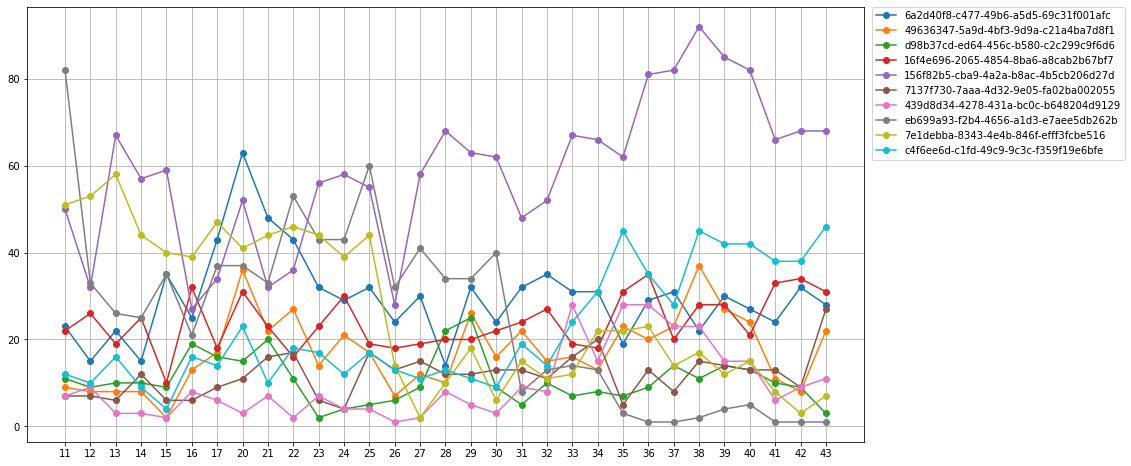

In [ ]:
def plot_visit_count(data):
    plt.figure(figsize=(15,8))
    for i in range(len(data)):
        plt.plot(list(map(str, data[i]["week_number"])), data[i]["raw_visit_counts"], "o-", label=data[i]["poi_id"][0])
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    plt.grid()
    plt.show()
plot_visit_count(data_missing)

In [ ]:
def plot_numerical_data(input_data):
    for data in input_data:
        x_time = list(map(str, data["week_number"]))
        y1 = data["visits_concentration"]
        y2 = data["distance_from_home"]
        y3 = data["median_dwell"]
        y = data["raw_visit_counts"]

        plt.figure(figsize=(8,4))
        plt.title(data["poi_id"][0])
        plt.plot(x_time, y1 / 10, "*-", label="visits_concentration / 10")
        plt.plot(x_time, y2 / 300, "^-", label="distance_from_home / 300")
        plt.plot(x_time, y3, "+-", label="median_dwell")
        plt.plot(x_time, y, "ro-", label='raw_visit_counts')
        plt.xticks(x_time)
        plt.grid()
        plt.legend()
        plt.show()

In [ ]:
plot_numerical_data(data_missing)

### Select POIs with no more than 5 weeks of data

In [ ]:
QUERY = """
SELECT poi_id
FROM (
    SELECT poi_id, COUNT(week_number) as week_count
    FROM ironhacks-covid19-data.ironhacks_covid19_competition.weekly_patterns
    GROUP BY poi_id
)
WHERE week_count <= 5
"""
query_job = bigquery_client.query(QUERY)
week_40_poi_less_5_weeks = query_job.to_dataframe()

In [ ]:
# select all POIs data with no more than 5 weeks of data
data_less_5 = []
for poi_id in week_40_poi_less_5_weeks["poi_id"]:
    QUERY="""
    SELECT *
    FROM ironhacks-covid19-data.ironhacks_covid19_competition.weekly_patterns
    WHERE poi_id="%s"
    """%(poi_id)
    query_job = bigquery_client.query(QUERY)
    data_less_5.append(query_job.to_dataframe())

In [ ]:
week_available = []
for i in range(len(data_less_5)):
    week_available.append(list(data_less_5[i]["week_number"]))

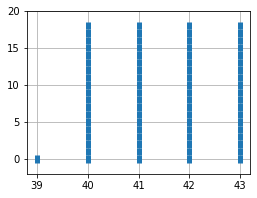

In [ ]:
plt.figure(figsize=(4,3))
plt.eventplot(week_available, linewidths=5)
plt.grid()
plt.show()

In [ ]:
plot_numerical_data(data_less_5)

The histgram result shows what weeks are included in the POIs with less than 5 weeks of data. It indicates that most of them are the last four weeks.

# Univariate models
The first trail is to test models on univariate variable, which is the raw_visit_counts. Steps are:
* Prepare the training data for each POI
* Train each model seperately
* Predict the upcoming week for each POI
* (Possible) As for POIs with no more than 5 weeks data, take an average of existing data as the prediction result.
* Calculate the MAE

In [ ]:
def mse_loss(y_true, y_pred):
    """
    MSE loss function
    Inputs param
    -------------------------
    y_true: list
        The ground truth values
    y_pred: list
    The predicted values
    -------------------------
    return: number
        mean square error of the two input lists
    """
    if(len(y_true) != len(y_pred)):
        print("True label len:" + str(len(y_true)) + ", Predict label len: " + str(len(y_pred)))
        raise Exception("Input lists have different length")
    mse = np.mean(np.array(y_true) - np.array(y_pred))**2
    return mse

In [ ]:
def mae_loss(y_true, y_pred):
    """
    MAE loss function
    Inputs param
    -------------------------
    y_true: list
        The ground truth values
    y_pred: list
    The predicted values
    -------------------------
    return: number
        mean absolute error of the two input lists
    """
    if(len(y_true) != len(y_pred)):
        print("True label len:" + str(len(y_true)) + ", Predict label len: " + str(len(y_pred)))
        raise Exception("Input lists have different length")
    mae = np.mean(np.absolute(np.array(y_true) - np.array(y_pred)))
    return mae

### For the POIs with no more than 5 weeks of data
Extract all weeks _raw_visit_counts_ data from the database

In [ ]:
week_visit_less_5 = {} # dict stores all visit count grouped by week, example: week_visit_less_5[40] retrieves week 40's raw_visit_count of all selected POIs
poi_ids_less_5 = [] # list stores all selected POIs' IDs
for data in data_less_5:
    poi_ids_less_5.append(data["poi_id"][0])
    if not week_visit_less_5:
        for i in range(len(data["raw_visit_counts"])):
            week_visit_less_5[data["week_number"][i]] = []
    for i in range(len(data["raw_visit_counts"])):
        week_visit_less_5[data["week_number"][i]].append(data["raw_visit_counts"][i])
print(poi_ids_less_5)
print(week_visit_less_5)

['d70a16ea-4982-4391-b7bd-6789f7018718', 'e71e79cd-71ae-4fd3-abf8-34f31a384702', '5576691b-4038-4b20-9736-4fc4c6e3a65f', '780472e8-9738-4832-a3d5-9736ed0a8f93', 'b5bbc683-775d-4fb5-b120-1c304302e136', '2d4ebc33-75c8-4822-a48d-57401f36ddfc', 'db4b221a-b849-4ffe-ac01-b26d46a15e57', 'e3a4fcba-f285-4113-81f5-dab8df7a4c41', '03e9a7b8-8502-4587-aef8-874041b57fd9', '77baea34-296d-4f0f-9b0b-1e191233101a', '48337bca-d4fd-46bf-b70a-9ada732d116a', '9ea86083-43d8-43b0-b014-3136616c32b7', '235937be-0295-4874-a3a7-7956e559a834', '67dfe851-d702-494b-9ee6-e68c836dcf84', 'a4ad5af3-ece6-4298-ac4a-e0a0af6329fb', '5919c7d1-c861-4d92-860e-3ef51f52f054', '72e0f3da-e654-43b9-8a4b-e21dba4101ef', '35644203-45ba-4f4a-9ee0-942a392927e8', 'a0d73d31-39d0-4753-8d12-edf8b44d31b2']
{39: [526], 40: [342, 46, 9, 261, 396, 63, 1, 7, 2, 9, 159, 33, 78, 5, 18, 683, 118, 8, 8], 41: [304, 42, 9, 229, 390, 54, 2, 4, 5, 12, 157, 35, 80, 6, 18, 669, 83, 2, 8], 42: [312, 40, 6, 237, 377, 75, 3, 2, 3, 12, 104, 41, 74, 7, 22, 653

### Using average model
Calculate the average _raw_visit_counts_ of the existing data as the prediction

In [ ]:
average_predict_result_less_5 = []
for data in data_less_5:
    average_predict_result_less_5.append(np.rint(data["raw_visit_counts"].sum() / len(data["raw_visit_counts"])))

sum_mae = 0
for i in range(4):
    mae = mae_loss(week_visit_less_5[i + 40], np.array(average_predict_result_less_5))
    sum_mae += mae
    print("MAE Loss for week " + str(i + 40) + " is: " + str(mae))
print("Average MAE is: " + str(sum_mae / 4))

MAE Loss for week 40 is: 7.2105263157894735
MAE Loss for week 41 is: 9.68421052631579
MAE Loss for week 42 is: 11.473684210526315
MAE Loss for week 43 is: 12.157894736842104
Average MAE is: 10.131578947368421


### Linear regression model
Fit a linear regression model and predict the result.

In [ ]:
from sklearn.linear_model import LinearRegression

linear_predict_result_less_5 = []
for data in data_less_5:
    X = np.array(data["week_number"]).reshape(-1, 1)
    y = np.array(data["raw_visit_counts"]).reshape(-1, 1)
    model = LinearRegression()
    model.fit(X, y)
    pred = model.predict(np.array([40, 41, 42, 43, 44]).reshape(-1, 1))
    linear_predict_result_less_5.append(np.rint(pred.reshape(1, -1)[0]))

sum_mae = 0
for i in range(np.array(linear_predict_result_less_5).shape[1] - 1):
    mae = mae_loss(week_visit_less_5[i + 40], np.array(linear_predict_result_less_5)[:, i])
    sum_mae += mae
    print("MAE Loss for week " + str(i + 40) + " is: " + str(mae))
print("Average MAE is: " + str(sum_mae / 4))

MAE Loss for week 40 is: 6.052631578947368
MAE Loss for week 41 is: 8.210526315789474
MAE Loss for week 42 is: 8.31578947368421
MAE Loss for week 43 is: 7.473684210526316
Average MAE is: 7.5131578947368425


### Support vector regression model (kernel='linear')
Fit an SVR model and predict the result.

In [ ]:
from sklearn.svm import SVR

SVR_predict_result_less_5 = []
for data in data_less_5:
    X = np.array(data["week_number"]).reshape(-1, 1)
    y = np.array(data["raw_visit_counts"]).reshape(-1, 1)
    model = SVR(kernel='linear')
    model.fit(X, y)
    pred = model.predict(np.array([40, 41, 42, 43, 44]).reshape(-1, 1))
    SVR_predict_result_less_5.append(list(np.rint(pred)))

sum_mae = 0
for i in range(np.array(SVR_predict_result_less_5).shape[1] - 1):
    mae = mae_loss(week_visit_less_5[i + 40], np.array(SVR_predict_result_less_5)[:, i])
    sum_mae += mae
    print("MAE Loss for week " + str(i + 40) + " is: " + str(mae))
print("Average MAE is: " + str(sum_mae / 4))

MAE Loss for week 40 is: 4.157894736842105
MAE Loss for week 41 is: 6.7894736842105265
MAE Loss for week 42 is: 10.157894736842104
MAE Loss for week 43 is: 8.263157894736842
Average MAE is: 7.342105263157895


### KNN regression model (N = 2)
Fit a KNN regression model and predict the result. n_neighbors = 2

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn_predict_result_less_5 = []
for data in data_less_5:
    X = np.array(data["week_number"]).reshape(-1, 1)
    y = np.array(data["raw_visit_counts"]).reshape(-1, 1)
    model = KNeighborsRegressor(n_neighbors = 2)
    model.fit(X, y)
    pred = model.predict(np.array([40, 41, 42, 43, 44]).reshape(-1, 1))
    knn_predict_result_less_5.append(list((np.rint(pred).reshape(1, -1)[0])))

sum_mae = 0
for i in range(np.array(knn_predict_result_less_5).shape[1] - 1):
    mae = mae_loss(week_visit_less_5[i + 40], np.array(knn_predict_result_less_5)[:, i])
    sum_mae += mae
    print("MAE Loss for week " + str(i + 40) + " is: " + str(mae))
print("Average MAE is: " + str(sum_mae / 4))

MAE Loss for week 40 is: 8.157894736842104
MAE Loss for week 41 is: 4.157894736842105
MAE Loss for week 42 is: 7.052631578947368
MAE Loss for week 43 is: 7.578947368421052
Average MAE is: 6.736842105263157


### RandomForest regression model
Fit a RandomForest regression model and predict the result.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_predict_result_less_5 = []
for data in data_less_5:
    X = np.array(data["week_number"]).reshape(-1, 1)
    y = np.array(data["raw_visit_counts"]).reshape(-1, 1)
    model = RandomForestClassifier(max_features=None)
    model.fit(X, y)
    pred = model.predict(np.array([40, 41, 42, 43, 44]).reshape(-1, 1))
    rf_predict_result_less_5.append(list((np.rint(pred).reshape(1, -1)[0])))

sum_mae = 0
for i in range(np.array(rf_predict_result_less_5).shape[1] - 1):
    mae = mae_loss(week_visit_less_5[i + 40], np.array(rf_predict_result_less_5)[:, i])
    sum_mae += mae
    print("MAE Loss for week " + str(i + 40) + " is: " + str(mae))
print("Average MAE is: " + str(sum_mae / 4))

MAE Loss for week 40 is: 0.0
MAE Loss for week 41 is: 0.0
MAE Loss for week 42 is: 0.0
MAE Loss for week 43 is: 0.0
Average MAE is: 0.0


#### As the results shown above, KNN is selected to predict the POIs with no more than 5 weeks of data.

In [ ]:
poi_less_5_week_44_pred = {"poi_id": poi_ids_less_5, "raw_visit_counts": np.array(knn_predict_result_less_5)[:, -1]}
poi_less_5_week_44_pred_df = pd.DataFrame.from_dict(poi_less_5_week_44_pred)
poi_less_5_week_44_pred_df

,poi_id,raw_visit_counts
0,d70a16ea-4982-4391-b7bd-6789f7018718,321.0
1,e71e79cd-71ae-4fd3-abf8-34f31a384702,40.0
2,5576691b-4038-4b20-9736-4fc4c6e3a65f,12.0
3,780472e8-9738-4832-a3d5-9736ed0a8f93,252.0
4,b5bbc683-775d-4fb5-b120-1c304302e136,370.0
5,2d4ebc33-75c8-4822-a48d-57401f36ddfc,70.0
6,db4b221a-b849-4ffe-ac01-b26d46a15e57,4.0
7,e3a4fcba-f285-4113-81f5-dab8df7a4c41,4.0
8,03e9a7b8-8502-4587-aef8-874041b57fd9,3.0
9,77baea34-296d-4f0f-9b0b-1e191233101a,11.0


### _Just testing the KNN model for the entire dataset_

In [ ]:
# select all POIs
QUERY = """
SELECT poi_id
FROM ironhacks-covid19-data.ironhacks_covid19_competition.prediction_list_poi
"""
query_job = bigquery_client.query(QUERY)
all_poi_id = query_job.to_dataframe()

In [ ]:
data_all = []
for poi_id in all_poi_id["poi_id"]:
    QUERY="""
    SELECT poi_id, week_number, raw_visit_counts
    FROM ironhacks-covid19-data.ironhacks_covid19_competition.weekly_patterns
    WHERE poi_id="%s"
    """%(poi_id)
    query_job = bigquery_client.query(QUERY)
    data_all.append(query_job.to_dataframe())

In [ ]:
week_all = {} # dict stores all visit count grouped by week
poi_ids_all = all_poi_id["poi_id"].tolist() # list stores all selected POIs' IDs
for data in data_all:
    for i in range(len(data["raw_visit_counts"])):
        week_all[data["week_number"][i]] = []
            
for data in data_all:
    for i in range(len(data["raw_visit_counts"])):
        week_all[data["week_number"][i]].append(data["raw_visit_counts"][i])

In [ ]:
knn_predict_all = []
for data in data_all:
    X = np.array(data["week_number"]).reshape(-1, 1)
    y = np.array(data["raw_visit_counts"]).reshape(-1, 1)
    model = KNeighborsRegressor(n_neighbors = 2)
    model.fit(X, y)
    pred = model.predict(np.array([40, 41, 42, 43, 44]).reshape(-1, 1))
    knn_predict_all.append(list((np.rint(pred).reshape(1, -1)[0])))

In [ ]:
sum_mae = 0
for i in range(4):
    mae = mae_loss(week_all[i + 40], np.array(knn_predict_all)[:, i])
    sum_mae += mae
    print("MAE Loss for week " + str(i + 40) + " is: " + str(mae))
print("Average MAE is: " + str(sum_mae / 4))

MAE Loss for week 40 is: 9.459534368070953
MAE Loss for week 41 is: 6.42239467849224
MAE Loss for week 42 is: 6.976164079822617
MAE Loss for week 43 is: 7.635254988913526
Average MAE is: 7.623337028824834


In [ ]:
knn_all_poi_univariate_predict = {"poi_id": poi_ids_all, "raw_visit_counts": np.array(knn_predict_all)[:, -1]}
knn_all_poi_univariate_predict_df = pd.DataFrame.from_dict(knn_all_poi_univariate_predict)
knn_all_poi_univariate_predict_df

,poi_id,raw_visit_counts
0,ad5fbefe-9e6a-47da-8011-8dadd9ad4cfe,4.0
1,0cd903d2-00a1-44ac-b262-fbc7475eb2bd,4.0
2,780472e8-9738-4832-a3d5-9736ed0a8f93,252.0
3,e9316e9d-8db6-4134-8a50-1c1da16fb9bc,44.0
4,5545ebf0-4f14-4f52-a499-8a5bdaa1df10,22.0
...,...,...
1799,8fb606bf-5918-4c16-af3c-1ab39ae46251,5.0
1800,801457d7-be9f-41c6-a87c-038ffd7f8b81,20.0
1801,a09953ae-81ed-4ed8-9dd5-be160e91297f,195.0
1802,45fe4a7f-30ec-4be2-ae71-34b833df2424,16.0


### Statistic Model predict function
Define the model function with the univariate models. Specificly, the selected models are
- Autoregression (AR)
- Moving Average (MA)
- Autoregressive Moving-Average (ARMA)
- Autoregressive Integrated Moving Average (ARIMA)
- Seasonal Autoregressive Integrated Moving-Average (SARIMA)
- Simple Exponential Smoothing (SES)
- Holt Winter’s Exponential Smoothing (HWES)
- Holt’s exponential smoothing (HOLT)

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import Holt

def univariate_model_predict(model_type, predict_week=44):
    """
    univariate models prediction function.
    param
    -------------------
    model_type : string
        Select the univariate model that to be trained.
    predict_week : number
        Only 43 and 44. The week to be predicted. Default week is 44.
    -------------------
    return
    predict : list
        Return predicted result of all poi visit counts in a list.
    model : object
        Trained model.
    """
    predict = []
    for data in poi_visit_array:
        if(predict_week == 43):
            train_data = data[:-1]
        elif(predict_week == 44):
            train_data = data
            
        if(model_type == "AR"):
            model = AutoReg(train_data, lags=1)
        elif(model_type == "MA"):
            model = ARIMA(train_data, order=(0, 0, 1))
        elif(model_type == "ARMA"):
            model = ARIMA(train_data, order=(2, 0, 1))
        elif(model_type == "ARIMA"):
            model = ARIMA(train_data, order=(1, 1, 1))
        elif(model_type == "SARIMA"):
            model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
        elif(model_type == "SES"):
            model = SimpleExpSmoothing(train_data)
        elif(model_type == "HWES"):
            model = ExponentialSmoothing(train_data)
        elif(model_type == "HOLT"):
            model = Holt(train_data)
            
        if(model_type == "SARIMA"):
            model_fit = model.fit(disp=False)
        else:
            model_fit = model.fit()
        
        if(model_type == "ARIMA"):
            pred = model_fit.predict(len(train_data), len(train_data), typ="levels")
        else:
            pred = model_fit.predict(len(train_data), len(train_data))
        predict.append(np.rint(pred[0]))
    return predict, model_fit
    

In [ ]:
# AR model predict
ar_pred, ar_model = univariate_model_predict("AR", 43)
ar_mae = mae_loss(week_43_true, ar_pred)
print("AR predict MAE for week 43 is: " + str(ar_mae))

AR predict MAE for week 43 is: 14.932926829268293


In [ ]:
# MA model predict
ma_pred, ma_model = univariate_model_predict("MA", 43)
ma_mae = mae_loss(week_43_true, ma_pred)
print("MA predict MSE for week 43 is: " + str(ma_mae))

MA predict MSE for week 43 is: 21.431818181818183


In [ ]:
# ARMA model predict
arma_pred, arma_model = univariate_model_predict("ARMA", 43)
arma_mae = mae_loss(week_43_true, arma_pred)
print("ARMA predict MSE for week 43 is: " + str(arma_mae))

ARMA predict MSE for week 43 is: 15.05820399113082


In [ ]:
# ARIMA model predict
arima_pred, arima_model = univariate_model_predict("ARIMA", 43)
arima_mae = mae_loss(week_43_true, arima_pred)
print("ARIMA predict MSE for week 43 is: " + str(arima_mae))

ARIMA predict MSE for week 43 is: 15.241130820399112


In [ ]:
# SARIMA model predict
sarima_pred, sarima_model = univariate_model_predict("SARIMA", 43)
sarima_mae = mae_loss(week_43_true, sarima_pred)
print("SARIMA predict MSE for week 43 is: " + str(sarima_mae))

SARIMA predict MSE for week 43 is: 15.241130820399112


In [ ]:
# SES model predict
ses_pred, ses_model = univariate_model_predict("SES", 43)
ses_mae = mae_loss(week_43_true, ses_pred)
print("SES predict MSE for week 43 is: " + str(ses_mae))

SES predict MSE for week 43 is: 14.394124168514413


In [ ]:
# HWES model predict
hwes_pred, hwes_model = univariate_model_predict("HWES", 43)
hwes_mae = mae_loss(week_43_true, hwes_pred)
print("HWES predict MSE for week 43 is: " + str(hwes_mae))

HWES predict MSE for week 43 is: 14.394124168514413


In [ ]:
# HOLT model predict
holt_pred, holt_model = univariate_model_predict("HOLT", 43)
holt_mae = mae_loss(week_43_true, holt_pred)
print("HOLT predict MSE for week 43 is: " + str(holt_mae))

HOLT predict MSE for week 43 is: 16.795454545454547


In [ ]:
# Select the best univariate model to predict week 44
best_pred, best_model = univariate_model_predict("SES")
week_44 = {'poi_id':poi_pred_id, 'raw_visit_counts': best_pred}
week_44_df = pd.DataFrame(week_44)
week_44_df

,poi_id,raw_visit_counts
0,00243ce2-6ecc-4c63-8d58-1138476289e4,6.0
1,00251e06-3f79-49f1-9e5a-7735e9b7836f,21.0
2,004e8d59-b91b-488a-b051-ed2769d8e8e3,193.0
3,00529b9c-54fe-4690-b319-48cf4c9eb226,30.0
4,005ec245-ca7b-4814-b706-8f0737c045b2,5.0
...,...,...
1799,ff017941-e5c5-4c3e-ad8e-51bee7a0d3f3,211.0
1800,ff047527-176f-4d9b-9d91-0d0ab8805a44,14.0
1801,ffa5b55e-5f61-4cd7-8f66-741f492c34c6,150.0
1802,ffdda836-f200-470e-9e9d-c8917a164043,9.0


In [ ]:
week_44_df.to_csv("prediction_list_poi.csv", index=False)

In [ ]:

!pip install pmdarima

### Use auto_arima to select univariate models for each POI

In [ ]:
from pmdarima import auto_arima
def auto_univariate_predict(predict_week=44):
    prediction = []
    for data in poi_visit_array:
        if(predict_week == 43):
            train_data = data[:-1]
        elif(predict_week == 44):
            train_data = data
        result = auto_arima(train_data, start_p=1, start_q=1, max_p=10, max_d=7,max_q=10, max_P=4, max_D=4,max_Q=4)
        pred = np.around(result.fit_predict(train_data, n_periods=1))
        prediction.append(pred)
    return prediction

auto_model_week_43_pred = auto_univariate_predict(predict_week=43)
print(mae_loss(week_43_true, auto_model_week_43_pred))

116.41370986376664


## LSTM model

In [ ]:

!pip install keras
!pip install tensorflow

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

def lstm_univariate_model(n_feature):
    model = Sequential()
#     model.add(Dense(10, activation="relu"))
    model.add(LSTM(4, input_shape=(1, n_feature)))
    model.add(Dense(1))
    model.compile(loss="mae", optimizer="adam", metrics=['accuracy'])
    return model

In [ ]:
# split into train and test sets
dataset = poi_visit_array[0][:-1]
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
print(train, test)

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

look_back=2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

lstm_uni_model = lstm_univariate_model(look_back)
lstm_uni_model.summary()
lstm_uni_data = lstm_uni_model.fit(trainX, trainY, validation_data=(testX, testY), epochs=1000, batch_size=1, verbose=2)

In [ ]:
np.rint(lstm_uni_model.predict(testX)[-1])

array([4.], dtype=float32)

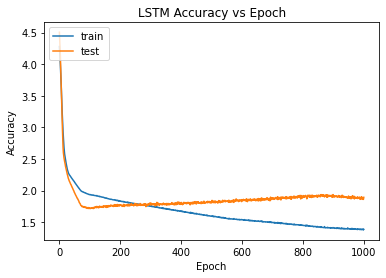

In [ ]:
plt.figure()
plt.plot(lstm_uni_data.history['loss'])
plt.plot(lstm_uni_data.history['val_loss'])
plt.title('LSTM Accuracy vs Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
POI_CONCEN = {k:[] for k in POI_ID}
POI_MED_DWELL = {k:[] for k in POI_ID}

# init with all 0
for k in POI_CONCEN:
    for i in range(11,44):
        POI_CONCEN[k].append({i:0})
        POI_MED_DWELL[k].append({i:0})
        
for i in range(0,len(weekly_patterns_data)):
    for week_concen, week_med_dwell in zip(POI_CONCEN[weekly_patterns_data["poi_id"][i]], POI_MED_DWELL[weekly_patterns_data["poi_id"][i]]):
        if(weekly_patterns_data["week_number"][i] in week_concen):
                        week_concen[weekly_patterns_data["week_number"][i]] = weekly_patterns_data["visits_concentration"][i]
                        week_med_dwell[weekly_patterns_data["week_number"][i]] = weekly_patterns_data["median_dwell"][i]
poi_concen_df = pd.DataFrame.from_dict(POI_CONCEN)
poi_dwell_df = pd.DataFrame.from_dict(POI_MED_DWELL)

In [ ]:
for i in range(0, 33):
    for j in range(0, 1804):
        d1 = poi_concen_df.iloc[i,j]
        d2 = poi_dwell_df.iloc[i,j]
        poi_concen_df.iloc[i,j] = next(iter(d1.values()))
        poi_dwell_df.iloc[i,j] = next(iter(d2.values()))

In [ ]:
print(poi_visit_df.shape)
print(poi_concen_df.shape)
print(poi_dwell_df.shape)

In [ ]:
poi_concen_array = poi_concen_df.T.to_numpy()
poi_dwell_array = poi_dwell_df.T.to_numpy()

NUM_PLOTS = 1804
for l1, l2 in zip(poi_concen_array, poi_dwell_array):
    temp_sum1, temp_sum2 = 0, 0
    for i in range(2,7):
        temp_sum1 += l1[i]
        temp_sum2 += l2[i]

        if i == 6:
            l1[i+1] = temp_sum1 / 5
            l2[i+1] = temp_sum2 / 5
            temp_sum1 += l1[i+1] - l1[2]
            temp_sum2 += l2[i+1] - l2[2]
            l1[i+2] = temp_sum1 / 5
            l2[i+2] = temp_sum2 / 5
            
plt.figure(figsize=(15,5))
for i in range(0, NUM_PLOTS):
    plt.plot(poi_concen_array[i])
    
plt.figure(figsize=(15,5))
for i in range(0, NUM_PLOTS):
    plt.plot(poi_dwell_array[i])

In [ ]:
### TODO change it!!!!
from statsmodels.tsa.vector_ar.var_model import VAR
from random import random
data = []
for i in range(100):
    v1 = i + random()
    v2 = v1 + random()
    v3 = v2 + random()
    row = [v1, v2, v3]
    data.append(row)
model = VAR(data)
model_fit = model.fit()
# make prediction
yhat = model_fit.forecast(model_fit.y, steps=10)
print(yhat)

[[100.33382282 100.80847979 101.17674311]
 [101.33181272 101.81319217 102.2230662 ]
 [102.32875227 102.81134276 103.21327589]
 [103.32584419 103.80897534 104.2099197 ]
 [104.32298401 104.80654484 105.20550124]
 [105.32019597 105.80417301 106.20128148]
 [106.31747797 106.80186901 107.19710928]
 [107.31483049 107.7996353  108.19301007]
 [108.31225351 108.79747207 109.18898079]
 [109.30974704 109.79537937 110.18502197]]


In [ ]:
# normal lstm
print(poi_visit_array)
print(poi_concen_array)
print(poi_dwell_array)

In [ ]:
# look back steps
# convert to [rows, columns] structure


aaa = 0
in_seq1 = poi_dwell_array[aaa][:-1].reshape((len(poi_dwell_array[aaa][:-1]), 1))
in_seq2 = poi_concen_array[aaa][:-1].reshape((len(poi_concen_array[aaa][:-1]), 1))
out_seq = poi_visit_array[aaa][:-1].reshape((len(poi_visit_array[aaa][:-1]), 1))
in_seq1 = nor_seq(in_seq1)
in_seq2 = nor_seq(in_seq2)

# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 2
# convert into input/output
X, y = split_sequences(dataset, n_steps)
print(X.shape, y.shape)
# summarize the data
for i in range(len(X)):
    print(X[i], y[i])
# print(np.array(in_seq1).astype(None))

In [ ]:
n_features = X.shape[2]
x_input = []
for n in range(n_steps):
    x_input.append([in_seq1[n-n_steps], in_seq2[n-n_steps]])
x_input = np.array(x_input).reshape((1, n_steps, n_features)).astype(None)
print(x_input)

[[[0.0501139  0.183673  ]
  [0.64464692 0.5       ]]]


In [ ]:
n_features = X.shape[2]
model = Sequential()
model.add(LSTM(5, activation='relu', input_shape=(n_steps, n_features)))
# model.add(Dense(8, activation='relu'))
# model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')
model_data = model.fit(X, y, epochs=500, batch_size=8, verbose=0, shuffle=False)
yhat = model.predict(x_input)
print(np.rint(yhat).astype(int)[0][0])

4


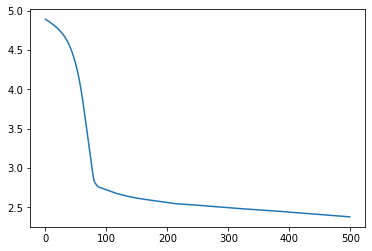

In [ ]:
plt.plot(model_data.history['loss'])

In [ ]:
def multi_lstm(n_steps, n_features):
    """
    Multivariate LSTM model
    Input: param
    ------------------------
    n_steps: number
        Number of LSTM look back steps
    n_features: number
        Number of features used as X
    ------------------------
    return: object
        An LSTM model with input shape (n_steps, n_features)
    """
    model = Sequential()
    model.add(LSTM(5, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def nor_seq(seq):
    """
    Normalization function, normalize a list to 0~1 scale
    Input param
    ------------------------
    seq: list
        Input list to be normalized
    ------------------------
    return: list
        Normalized list
    """
    return [i/max(seq) for i in seq]

def split_sequences(sequences, n_steps):
    """
    split a multivariate sequence into samples
    # https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
    Input param
    ------------------------
    sequences: array
        Input array to be splited by looking back into features X and labels y
    n_steps: number
        Number of look back steps to generate the model formula
    ------------------------
    return
    ------------------------
    X: numpy array
        X feature array
    y: numpy array
        y labels
    """
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix >= len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X).astype(None), np.array(y).astype(None)

In [ ]:
def train_multi_lstm(n_steps = 2, epochs=500):
    """
    Use data to train individual LSTM models for each POI and predict.
    Input param
    -------------------------
    n_steps: number
        Number of LSTM look back steps, default 2
    epochs: number
        Training epochs, default 500
    -------------------------
    return: list, list
        return the LSTM predict results of all POIs visit count for week 43 and 44
    """
    predict_43 = []
    predict_44 = []

    for i in range(len(poi_visit_array)):
        in_seq1 = poi_dwell_array[i].reshape((len(poi_dwell_array[i]), 1))
        in_seq2 = poi_concen_array[i].reshape((len(poi_concen_array[i]), 1))
        out_seq = poi_visit_array[i].reshape((len(poi_visit_array[i]), 1))
        
        # normalize input features
        in_seq1 = nor_seq(in_seq1)
        in_seq2 = nor_seq(in_seq2)

        # horizontally stack columns
        dataset = np.hstack((in_seq1, in_seq2, out_seq))
        
        # convert into input/output
        X, y = split_sequences(dataset, n_steps)
        
        # create the LSTM model and train it
        model = multi_lstm(n_steps, n_features = X.shape[2])
        model.fit(X, y, epochs=epochs, batch_size=16, verbose=0, shuffle=False)
        
        # generate prediction features
        x_input_43 = []
        x_input_44 = []

        for n in range(n_steps):
            x_input_43.append([in_seq1[n-n_steps-1], in_seq2[n-n_steps-1]])
            x_input_44.append([in_seq1[n-n_steps], in_seq2[n-n_steps]])

        x_input_43 = np.array(x_input_43).reshape((1, n_steps, n_features)).astype(None)
        x_input_44 = np.array(x_input_44).reshape((1, n_steps, n_features)).astype(None)

        y_pred_43 = np.rint(model.predict(x_input_43)).astype(int)[0][0]
        y_pred_44 = np.rint(model.predict(x_input_44)).astype(int)[0][0]

        predict_43.append(y_pred_43)
        predict_44.append(y_pred_44)

        print(str(round(100*i/1804, 2))+"% "+str(y_pred_43)+", "+str(y_pred_44))
    return predict_43, predict_44

In [ ]:
import os, logging, time, datetime
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)
logging.getLogger("tensorflow_hub").setLevel(logging.CRITICAL)

start_time = time.time()
pred_43, pred_44 = train_multi_lstm()
print(datetime.timedelta(seconds=(time.time() - start_time)))

In [ ]:
lstm_mae = mae_loss(week_43_true, pred_43)
print(lstm_mae)
week_44_lstm = {'poi_id':poi_pred_id, 'raw_visit_counts': pred_44}
week_44_lstm_df = pd.DataFrame(week_44_lstm)
week_44_lstm_df.to_csv("submission_prediction_output.csv", index=False)
week_44_lstm_df

55.73115299334812


,poi_id,raw_visit_counts
0,00243ce2-6ecc-4c63-8d58-1138476289e4,6
1,00251e06-3f79-49f1-9e5a-7735e9b7836f,14
2,004e8d59-b91b-488a-b051-ed2769d8e8e3,1
3,00529b9c-54fe-4690-b319-48cf4c9eb226,36
4,005ec245-ca7b-4814-b706-8f0737c045b2,3
...,...,...
1799,ff017941-e5c5-4c3e-ad8e-51bee7a0d3f3,28
1800,ff047527-176f-4d9b-9d91-0d0ab8805a44,15
1801,ffa5b55e-5f61-4cd7-8f66-741f492c34c6,68
1802,ffdda836-f200-470e-9e9d-c8917a164043,10


## CNN model

In [ ]:
def cnn_model(n_steps=1, n_features=1):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mae')
    return model

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

cnn_predit_all = []

n_steps = 3
n_features = 1
i = 0
for data in data_all:
    X, y = create_dataset(data["raw_visit_counts"], look_back = n_steps)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    model = cnn_model(n_steps = n_steps, n_features = n_features)
    model.fit(X, y, epochs=1000, verbose = 0)
    input_x = np.array(data["raw_visit_counts"][-3:]).reshape(1, n_steps, 1)
    pred = np.rint(model.predict(input_x, verbose = 0))[0][0]
    print(str(i + 1) + "/1804: " + str(pred))
    i = i + 1
    cnn_predit_all.append(pred)

In [ ]:
print(mae_loss(week_all[43], cnn_predit_all))

9.512749445676276


In [ ]:
for i in range(len(cnn_predit_all)):
    if(cnn_predit_all[i] < 0):
        cnn_predit_all[i] = 0
print(mae_loss(week_all[43], cnn_predit_all))

9.240576496674057


In [ ]:
cnn_all_poi_univariate_predict = {"poi_id": poi_ids_all, "raw_visit_counts": np.array(cnn_predit_all)}
cnn_all_poi_univariate_predict_df = pd.DataFrame.from_dict(cnn_all_poi_univariate_predict)
cnn_all_poi_univariate_predict_df

,poi_id,raw_visit_counts
0,ad5fbefe-9e6a-47da-8011-8dadd9ad4cfe,5.0
1,0cd903d2-00a1-44ac-b262-fbc7475eb2bd,2.0
2,780472e8-9738-4832-a3d5-9736ed0a8f93,266.0
3,e9316e9d-8db6-4134-8a50-1c1da16fb9bc,50.0
4,5545ebf0-4f14-4f52-a499-8a5bdaa1df10,23.0
...,...,...
1799,8fb606bf-5918-4c16-af3c-1ab39ae46251,8.0
1800,801457d7-be9f-41c6-a87c-038ffd7f8b81,13.0
1801,a09953ae-81ed-4ed8-9dd5-be160e91297f,189.0
1802,45fe4a7f-30ec-4be2-ae71-34b833df2424,16.0
